# Number Plate Detection by Finding Contours


 

In [90]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [91]:
pip install opencv-python==4.5.3.56

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import the necessary libraries

In [92]:
import os
import numpy as np
import pandas as pd
import cv2
import imutils
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
from sklearn.metrics import f1_score


import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers

from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

## Load the image


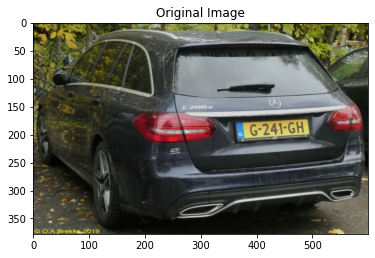

In [93]:
# Read the image file
image = cv2.imread('/content/drive/MyDrive/License-Plate-Number-Detection-main/test_dataset/images/25.jpg')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.show()

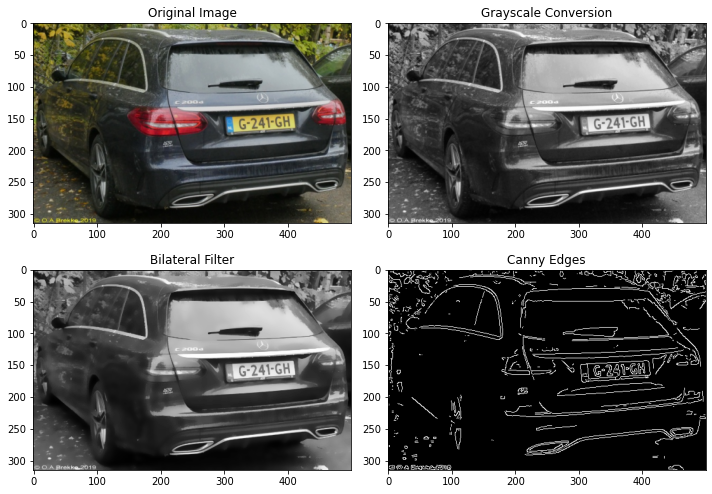

In [94]:
image = imutils.resize(image, width=500)
img=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the original image
fig, ax = plt.subplots(2, 2, figsize=(10,7))
ax[0,0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax[0,0].set_title('Original Image')

# RGB to Gray scale conversion
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ax[0,1].imshow(gray, cmap='gray')
ax[0,1].set_title('Grayscale Conversion')

# Noise removal with iterative bilateral filter(removes noise while preserving edges)
gray = cv2.bilateralFilter(gray, 11, 17, 17)
ax[1,0].imshow(gray, cmap='gray')
ax[1,0].set_title('Bilateral Filter')

# Find Edges of the grayscale image
edged = cv2.Canny(gray, 170, 200)
ax[1,1].imshow(edged, cmap='gray')
ax[1,1].set_title('Canny Edges')

fig.tight_layout()
plt.show()

# Find contours based on Edges
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
cnts=sorted(cnts, key = cv2.contourArea, reverse = True)[:30] #sort contours based on their area keeping minimum required area as '30' (anything smaller than this will not be considered)
NumberPlateCnt = None #we currently have no Number plate contour

# loop over our contours to find the best possible approximate contour of number plate
count = 0
for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:  # Select the contour with 4 corners
            NumberPlateCnt = approx #This is our approx Number Plate Contour
            x,y,w,h = cv2.boundingRect(c)
            ROI = img[y:y+h, x:x+w]
            break

if NumberPlateCnt is not None:
    # Drawing the selected contour on the original image
    cv2.drawContours(image, [NumberPlateCnt], -1, (0,255,0), 3)

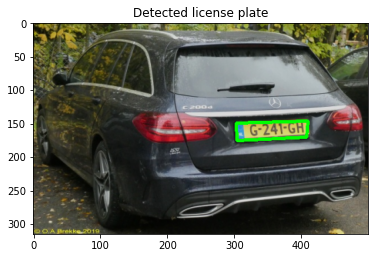

In [95]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Detected license plate")
plt.show()

The green bounding box shows the detected license plate.

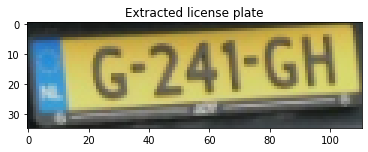

In [96]:
# Find bounding box and extract ROI
plt.imshow(ROI)
plt.title("Extracted license plate")
plt.show()

## Rotate the plate (if tilted)


In [97]:
print(NumberPlateCnt)

[[[410 146]]

 [[303 149]]

 [[304 175]]

 [[408 170]]]


In [98]:
# Distance between (x1, y1) and (x2, y2)
def dist(x1, x2, y1, y2):
    return ((x1-x2)**2+(y1-y2)**2)**0.5

In [99]:
idx=0
m=0
# To find the index of coordinate with maximum y-coordinate
for i in range(4):
    if NumberPlateCnt[i][0][1]>m:
        idx=i
        m=NumberPlateCnt[i][0][1]

# Assign index to the previous coordinate
if idx==0:
    pin=3
else:
    pin=idx-1

# Assign index to the next coordinate
if idx==3:
    nin=0
else:
    nin=idx+1

# Find distances between the acquired coordinate and its previous and next coordinate
p=dist(NumberPlateCnt[idx][0][0], NumberPlateCnt[pin][0][0], NumberPlateCnt[idx][0][1], NumberPlateCnt[pin][0][1])
n=dist(NumberPlateCnt[idx][0][0], NumberPlateCnt[nin][0][0], NumberPlateCnt[idx][0][1], NumberPlateCnt[nin][0][1])

# The coordinate that has more distance from the acquired coordinate is the required second bottom-most coordinate
if p>n:
    if NumberPlateCnt[pin][0][0]<NumberPlateCnt[idx][0][0]:
        left=pin
        right=idx
    else:
        left=idx
        right=pin
    d=p
else:
    if NumberPlateCnt[nin][0][0]<NumberPlateCnt[idx][0][0]:
        left=nin
        right=idx
    else:
        left=idx
        right=nin
    d=n
print(left, right)

2 3


In [100]:
left_x=NumberPlateCnt[left][0][0]
left_y=NumberPlateCnt[left][0][1]
right_x=NumberPlateCnt[right][0][0]
right_y=NumberPlateCnt[right][0][1]
print(left_x, left_y, right_x, right_y)

304 175 408 170


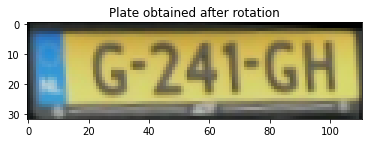

In [101]:
# Finding the angle of rotation by calculating sin of theta
opp=right_y-left_y
hyp=((left_x-right_x)**2+(left_y-right_y)**2)**0.5
sin=opp/hyp
theta=math.asin(sin)*57.2958

# Rotate the image according to the angle of rotation obtained
image_center = tuple(np.array(ROI.shape[1::-1]) / 2)
rot_mat = cv2.getRotationMatrix2D(image_center, theta, 1.0)
result = cv2.warpAffine(ROI, rot_mat, ROI.shape[1::-1], flags=cv2.INTER_LINEAR)

# The image can be cropped after rotation( since rotated image takes much more height)
if opp>0:
    h=result.shape[0]-opp//2
else:
    h=result.shape[0]+opp//2

result=result[0:h, :]
plt.imshow(result)
plt.title("Plate obtained after rotation")
plt.show()

## STEP 2) : Character Segmentation


In [102]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')
            plt.title('Predict Segments')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [103]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.title('Contour')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

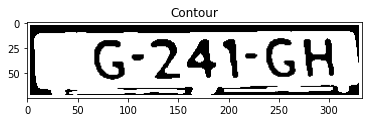

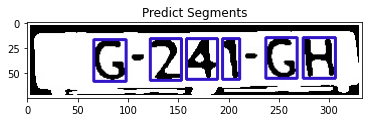

In [104]:
char=segment_characters(result)

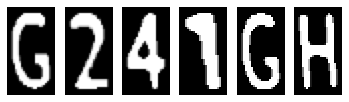

In [105]:
for i in range(len(char)):
    plt.subplot(1, len(char), i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')
plt.show()

## STEP 3) Character Recognition using CNN


In [106]:
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = '/content/drive/MyDrive/License-Plate-Number-Detection-main/data'
train_generator = train_datagen.flow_from_directory(
        path+'/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(
        path+'/val',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28 batch_size=1,
        class_mode= 'sparse')

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [107]:
K.clear_session()
model = Sequential()
model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics='accuracy')

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [108]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        23248     
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        131104    
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        131136    
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        65600     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 7, 7, 64)          0         
                                                        

In [109]:
batch_size = 1
result = model.fit(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      epochs = 25, verbose=1, callbacks=None)

Epoch 1/25
864/864 [==============================] - 451s 521ms/step - loss: 2.9935 - accuracy: 0.1759 - val_loss: 1.5235 - val_accuracy: 0.5093
Epoch 2/25
864/864 [==============================] - 62s 71ms/step - loss: 1.1923 - accuracy: 0.6389 - val_loss: 0.6280 - val_accuracy: 0.7870
Epoch 3/25
864/864 [==============================] - 63s 73ms/step - loss: 0.6258 - accuracy: 0.7998 - val_loss: 0.5263 - val_accuracy: 0.8148
Epoch 4/25
864/864 [==============================] - 61s 71ms/step - loss: 0.4037 - accuracy: 0.8762 - val_loss: 0.2277 - val_accuracy: 0.9491
Epoch 5/25
864/864 [==============================] - 62s 72ms/step - loss: 0.2756 - accuracy: 0.9178 - val_loss: 0.1645 - val_accuracy: 0.9398
Epoch 6/25
864/864 [==============================] - 63s 73ms/step - loss: 0.2210 - accuracy: 0.9248 - val_loss: 0.1390 - val_accuracy: 0.9444
Epoch 7/25
864/864 [==============================] - 62s 72ms/step - loss: 0.1998 - accuracy: 0.9363 - val_loss: 0.1282 - val_accurac

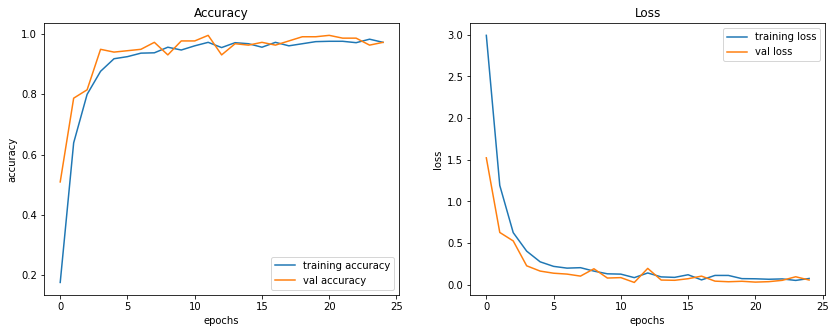

In [110]:
fig = plt.figure(figsize=(14,5))
grid=gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.plot(result.history['accuracy'], label='training accuracy')
plt.plot(result.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

fig.add_subplot(grid[1])
plt.plot(result.history['loss'], label='training loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

Save the model weights for future use.

In [111]:
# Save the weights
model.save_weights('/content/drive/MyDrive/License-Plate-Number-Detection-main/checkpoints1/my_checkpoint')

Since we saved only the model weights, we first need to create a model instance and then load the saved weights into the model.

In [112]:
# Create a new model instance
loaded_model = Sequential()
loaded_model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(MaxPooling2D(pool_size=(4, 4)))
loaded_model.add(Dropout(0.4))
loaded_model.add(Flatten())
loaded_model.add(Dense(128, activation='relu'))
loaded_model.add(Dense(36, activation='softmax'))

# Restore the weights
loaded_model.load_weights('/content/drive/MyDrive/License-Plate-Number-Detection-main/checkpoints1/my_checkpoint')

## Predict the license plate number


In [113]:
# Predicting the output
def fix_dimension(img): 
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
        return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        y_ = np.argmax(loaded_model.predict(img), axis=-1)[0]

        #y_ = loaded_model.predict_classes(img)[0] #predicting the class
        character = dic[y_]
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number
print(show_results())

1/1 [==============================] - 0s 28ms/step
G241GH


1/1 [==============================] - 0s 32ms/step


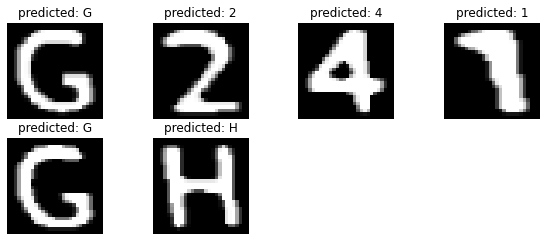

In [114]:
# Segmented characters and their predicted value.
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()

## Importing the dataset


In [118]:
labels=pd.read_excel('/content/labels.xlsx')
labels['ID']=labels['ID'].map(str)
labels

ID       NUMBER
0      1.0    KL55R2473
1      2.0  GJW115A1138
2      3.0    KL16J3636
3      4.0   MH20EE7598
4      5.0      PJJ1L76
..     ...          ...
161  162.0      DHF5B15
162  163.0      DBJ5R59
163  164.0      LVY8X45
164  165.0      YYD6B61
165  166.0      CHI4A30

[166 rows x 2 columns]

In [116]:
def show_results1(char):
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        y_ = np.argmax(loaded_model.predict(img), axis=-1)[0]

        #y_ = loaded_model.predict_classes(img)[0] #predicting the class
        character = dic[y_]
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

## Accuracy


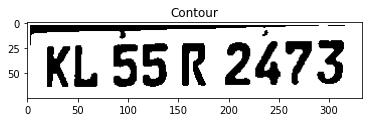

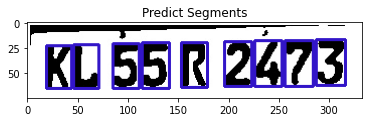

1/1 [==============================] - 0s 26ms/step
1


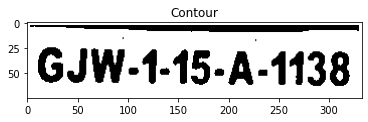

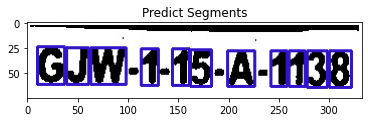

1/1 [==============================] - 0s 27ms/step
2


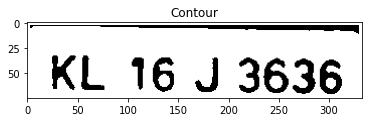

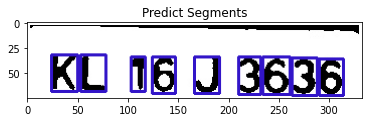

1/1 [==============================] - 0s 28ms/step
3


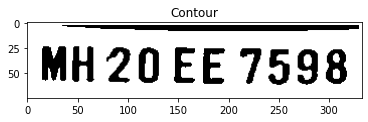

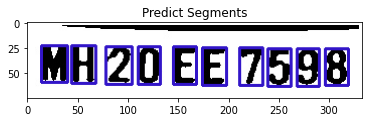

1/1 [==============================] - 0s 30ms/step
4


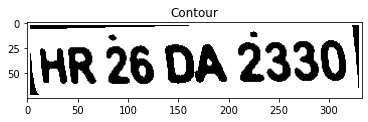

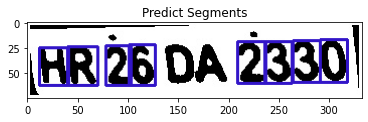

1/1 [==============================] - 0s 32ms/step
5


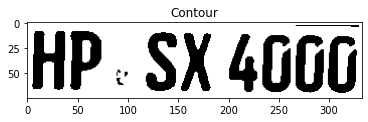

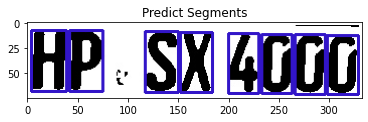

1/1 [==============================] - 0s 28ms/step
6


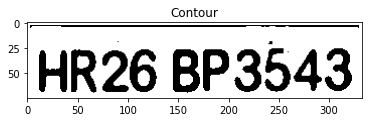

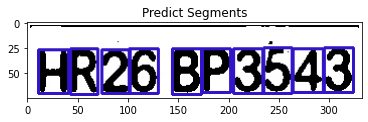

1/1 [==============================] - 0s 36ms/step
7


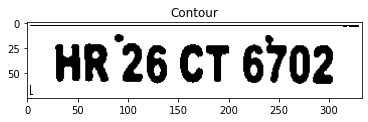

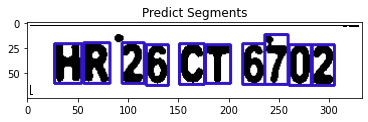

1/1 [==============================] - 0s 30ms/step
8


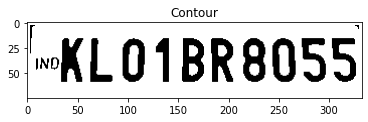

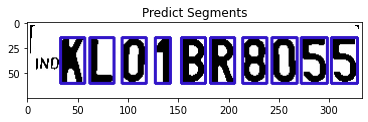

1/1 [==============================] - 0s 31ms/step
9


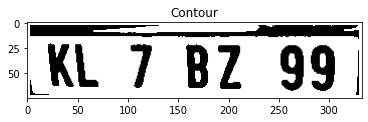

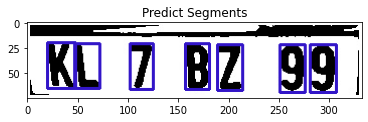

1/1 [==============================] - 0s 32ms/step
10


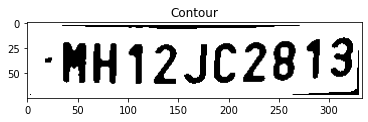

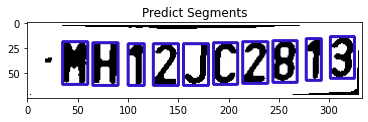

1/1 [==============================] - 0s 30ms/step
11


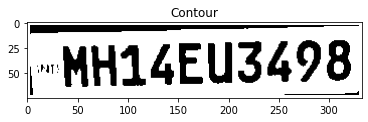

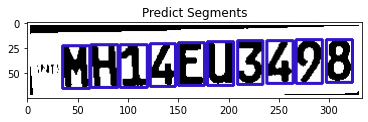

1/1 [==============================] - 0s 30ms/step
12


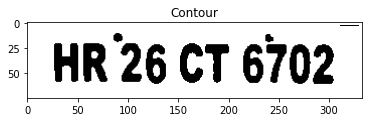

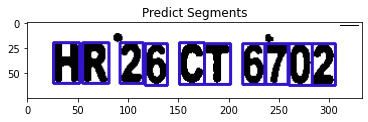

1/1 [==============================] - 0s 30ms/step
13


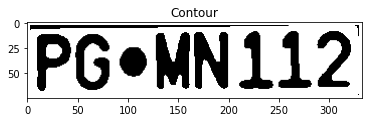

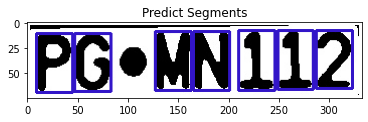

1/1 [==============================] - 0s 31ms/step
14


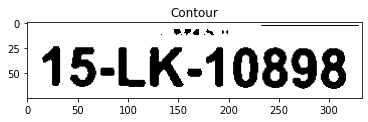

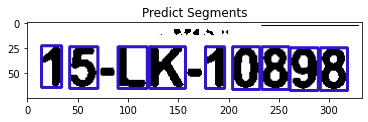

1/1 [==============================] - 0s 34ms/step
15


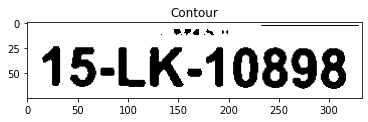

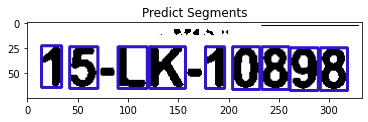

1/1 [==============================] - 0s 33ms/step
16


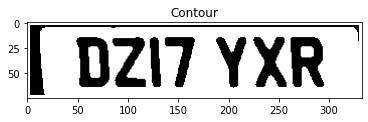

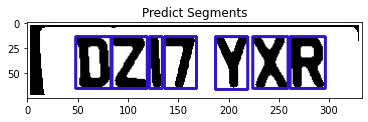

1/1 [==============================] - 0s 28ms/step
17


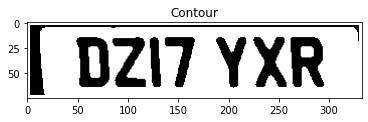

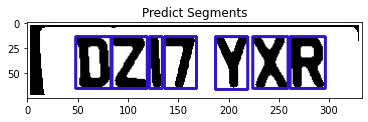

1/1 [==============================] - 0s 32ms/step
18


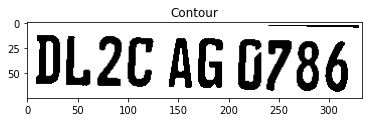

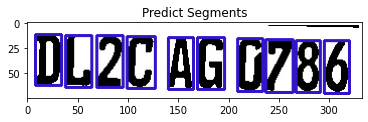

1/1 [==============================] - 0s 34ms/step
19


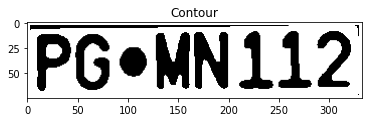

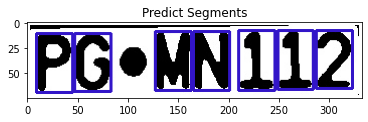

1/1 [==============================] - 0s 32ms/step
20


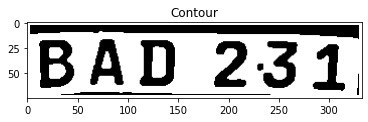

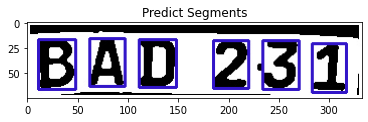

1/1 [==============================] - 0s 28ms/step
21


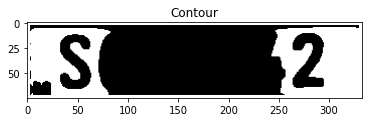

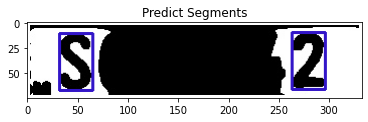

1/1 [==============================] - 0s 33ms/step
22


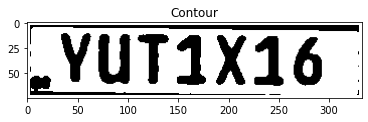

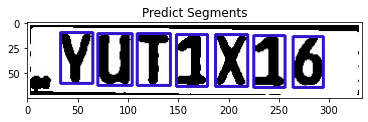

1/1 [==============================] - 0s 29ms/step
23


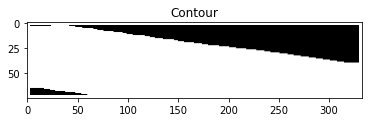

24


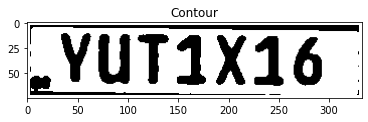

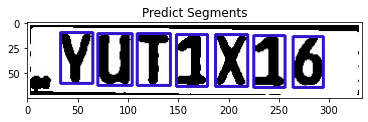

1/1 [==============================] - 0s 29ms/step
25


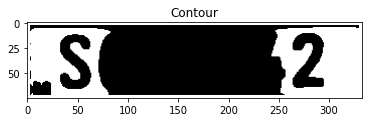

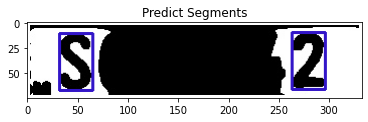

1/1 [==============================] - 0s 33ms/step
26


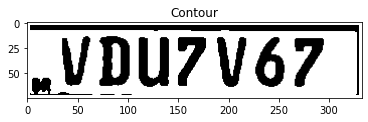

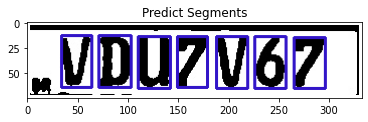

1/1 [==============================] - 0s 30ms/step
27


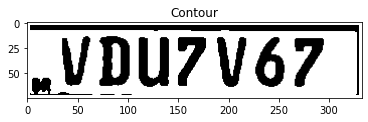

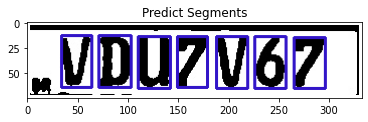

1/1 [==============================] - 0s 34ms/step
28


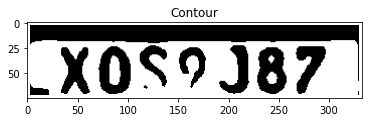

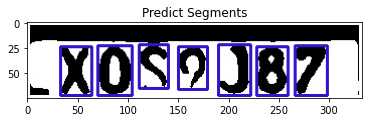

1/1 [==============================] - 0s 29ms/step
29


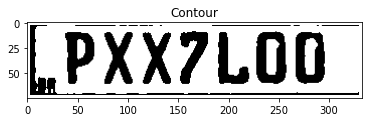

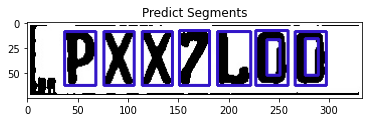

1/1 [==============================] - 0s 31ms/step
30


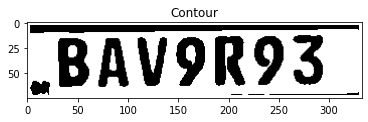

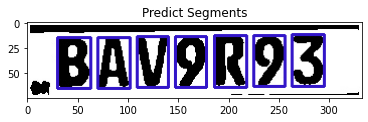

1/1 [==============================] - 0s 49ms/step
31


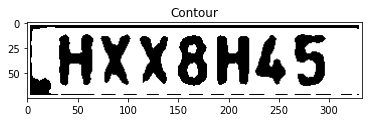

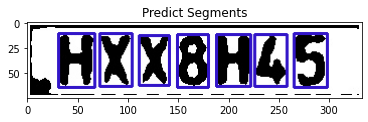

1/1 [==============================] - 0s 31ms/step
32


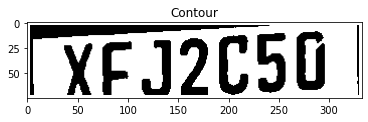

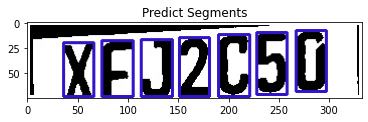

1/1 [==============================] - 0s 28ms/step
33


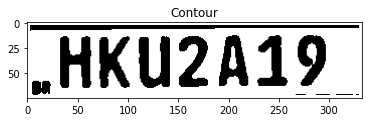

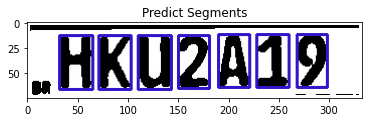

1/1 [==============================] - 0s 33ms/step
34


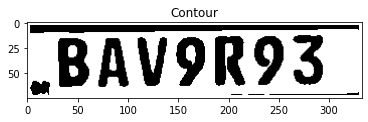

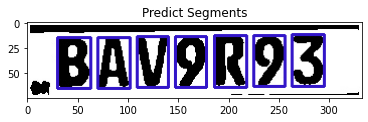

1/1 [==============================] - 0s 55ms/step
35


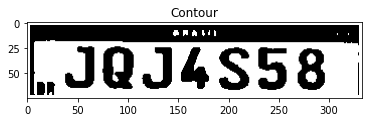

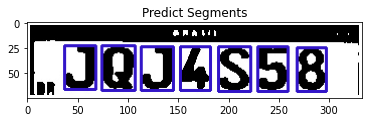

1/1 [==============================] - 0s 44ms/step
36


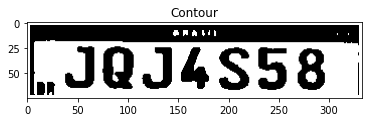

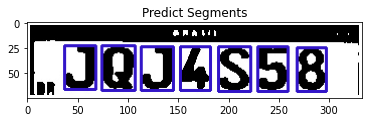

1/1 [==============================] - 0s 51ms/step
37


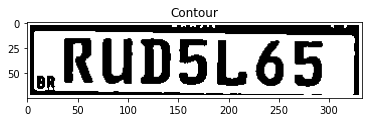

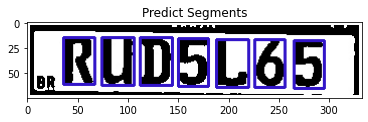

1/1 [==============================] - 0s 29ms/step
38


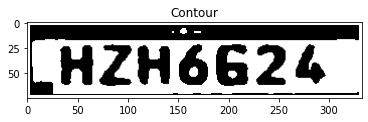

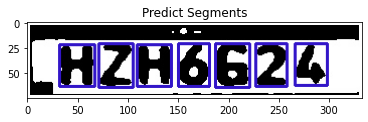

1/1 [==============================] - 0s 30ms/step
39


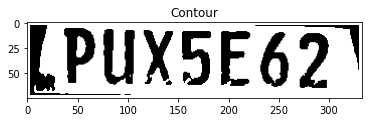

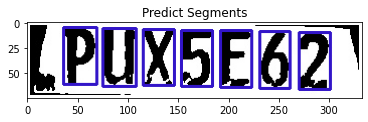

1/1 [==============================] - 0s 34ms/step
40


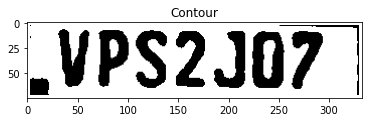

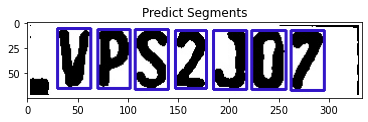

1/1 [==============================] - 0s 36ms/step
41


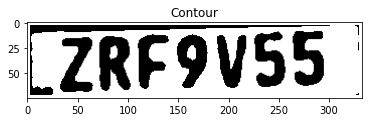

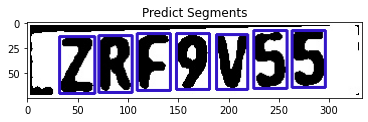

1/1 [==============================] - 0s 29ms/step
42


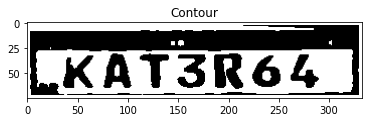

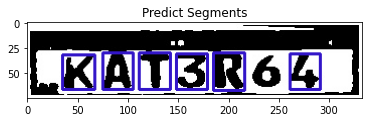

1/1 [==============================] - 0s 34ms/step
43


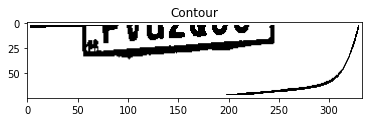

44


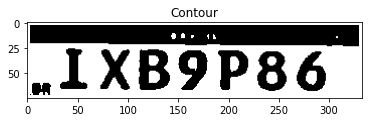

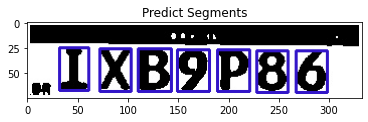

1/1 [==============================] - 0s 31ms/step
45


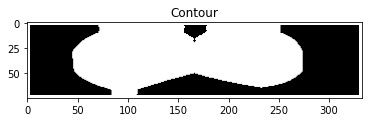

46


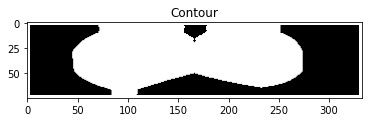

47


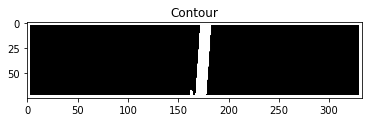

48


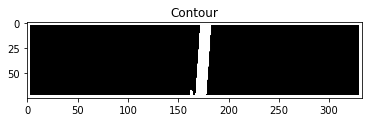

49


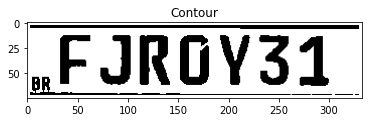

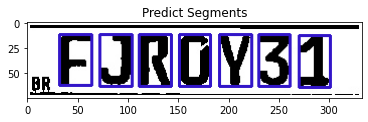

1/1 [==============================] - 0s 34ms/step
50


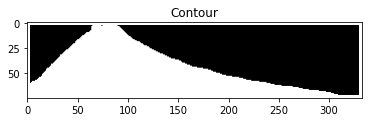

51


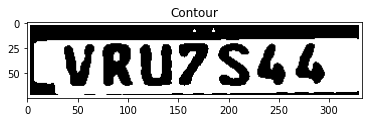

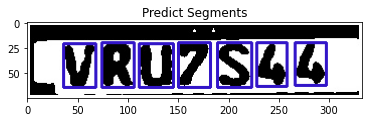

1/1 [==============================] - 0s 31ms/step
52


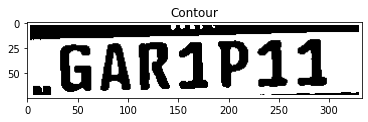

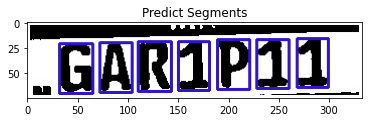

1/1 [==============================] - 0s 29ms/step
53


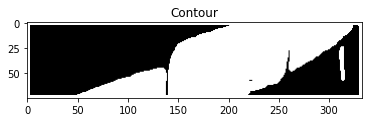

54


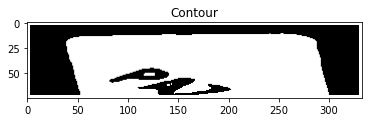

55


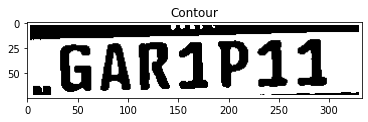

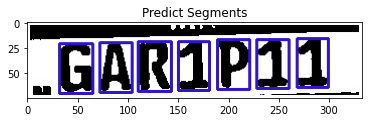

1/1 [==============================] - 0s 30ms/step
56


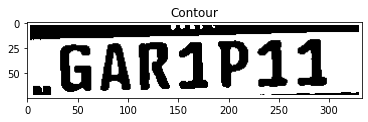

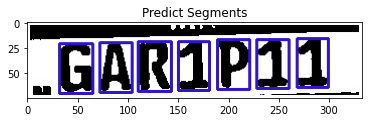

1/1 [==============================] - 0s 36ms/step
57


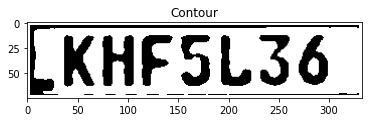

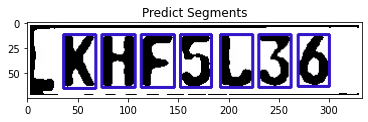

1/1 [==============================] - 0s 34ms/step
58


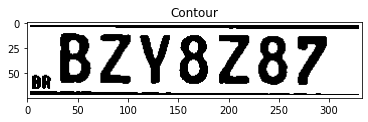

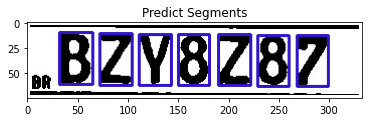

1/1 [==============================] - 0s 37ms/step
59


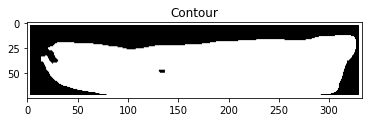

60


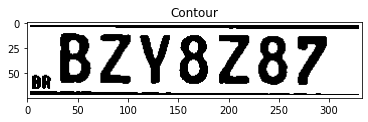

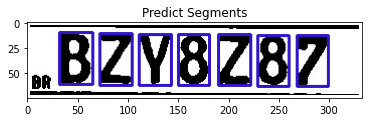

1/1 [==============================] - 0s 35ms/step
61


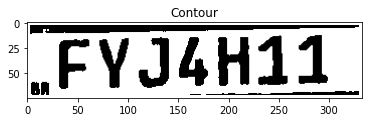

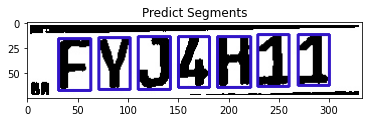

1/1 [==============================] - 0s 31ms/step
62


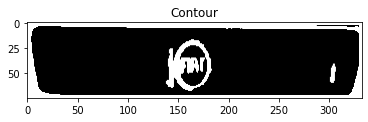

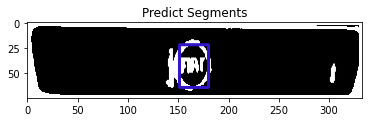

1/1 [==============================] - 0s 32ms/step
63


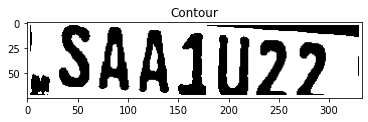

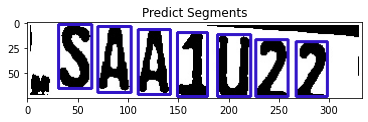

1/1 [==============================] - 0s 32ms/step
64


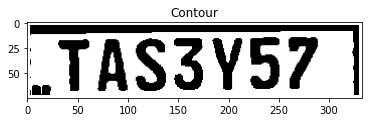

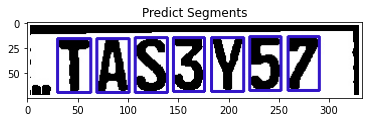

1/1 [==============================] - 0s 34ms/step
65


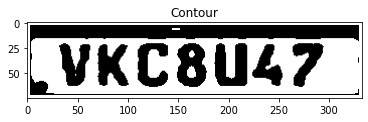

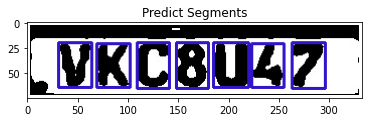

1/1 [==============================] - 0s 31ms/step
66


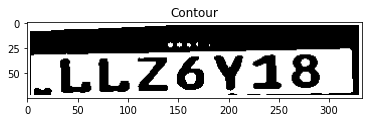

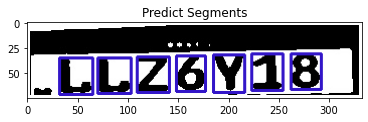

1/1 [==============================] - 0s 33ms/step
67


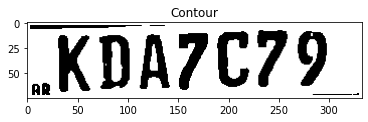

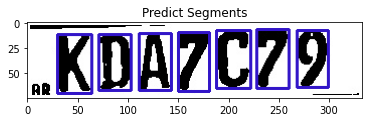

1/1 [==============================] - 0s 34ms/step
68


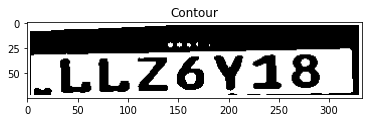

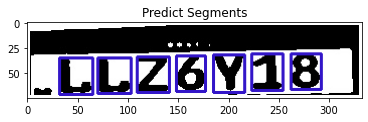

1/1 [==============================] - 0s 29ms/step
69


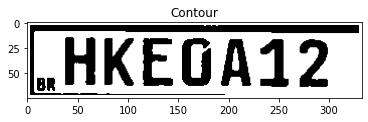

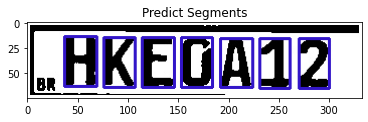

1/1 [==============================] - 0s 30ms/step
70


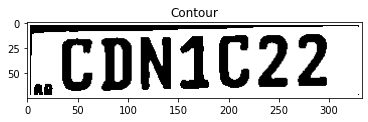

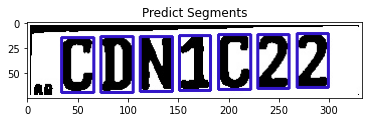

1/1 [==============================] - 0s 35ms/step
71


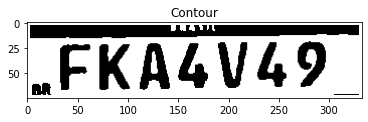

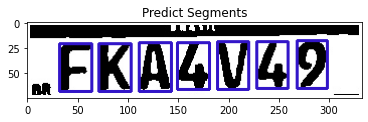

1/1 [==============================] - 0s 32ms/step
72


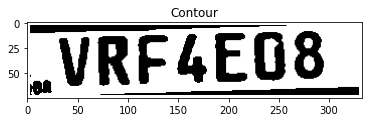

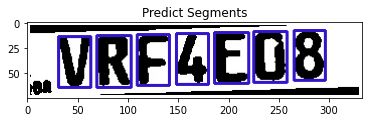

1/1 [==============================] - 0s 35ms/step
73


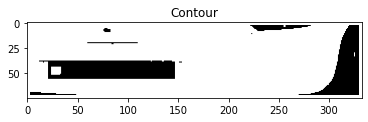

74


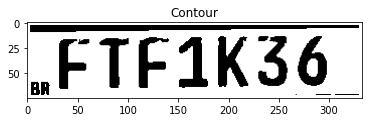

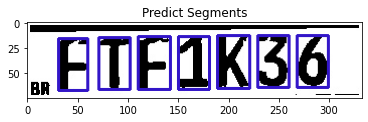

1/1 [==============================] - 0s 32ms/step
75


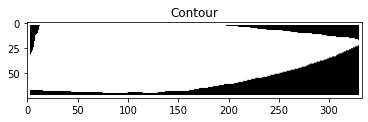

76


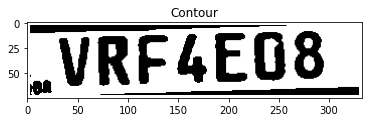

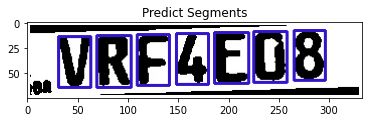

1/1 [==============================] - 0s 34ms/step
77


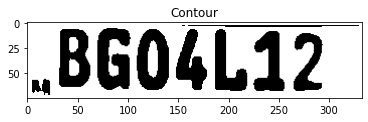

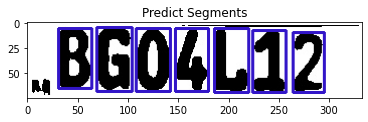

1/1 [==============================] - 0s 35ms/step
78


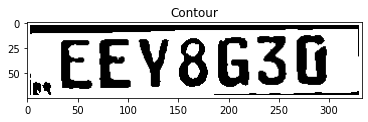

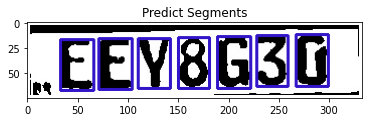

1/1 [==============================] - 0s 35ms/step
79


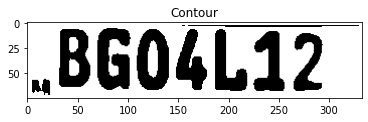

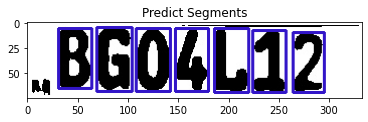

1/1 [==============================] - 0s 37ms/step
80


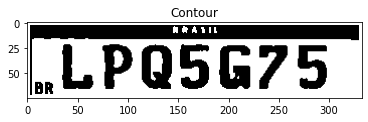

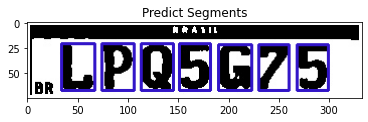

1/1 [==============================] - 0s 30ms/step
81


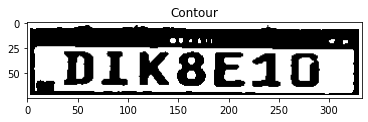

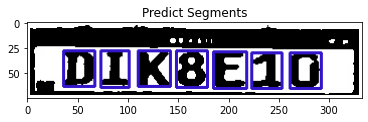

1/1 [==============================] - 0s 33ms/step
82


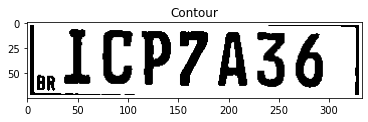

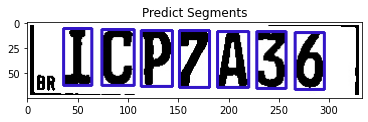

1/1 [==============================] - 0s 44ms/step
83


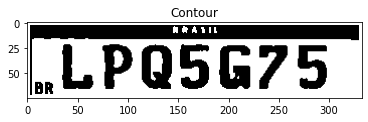

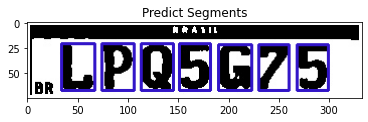

1/1 [==============================] - 0s 33ms/step
84


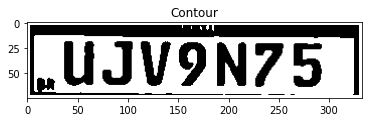

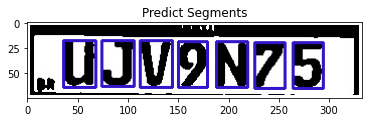

1/1 [==============================] - 0s 39ms/step
85


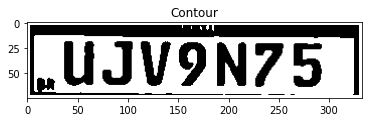

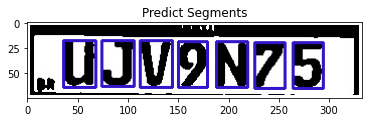

1/1 [==============================] - 0s 34ms/step
86


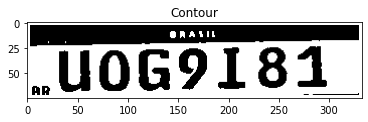

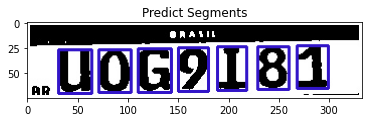

1/1 [==============================] - 0s 35ms/step
87


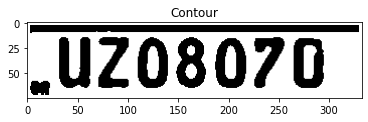

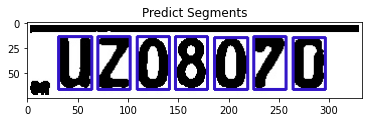

1/1 [==============================] - 0s 35ms/step
88


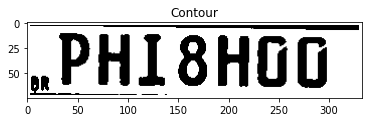

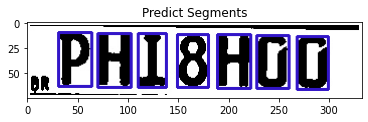

1/1 [==============================] - 0s 37ms/step
89


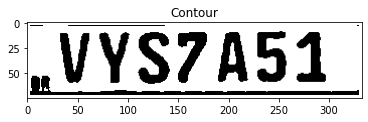

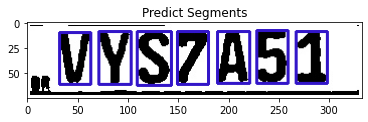

1/1 [==============================] - 0s 38ms/step
90


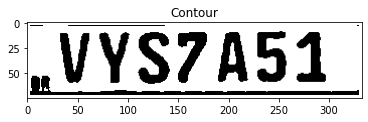

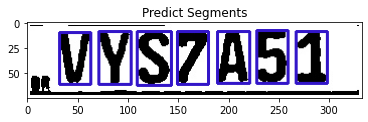

1/1 [==============================] - 0s 42ms/step
91


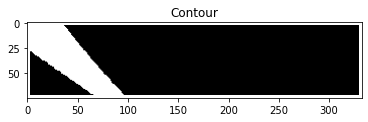

92


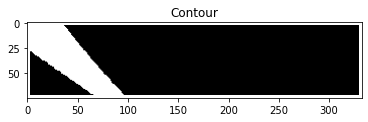

93


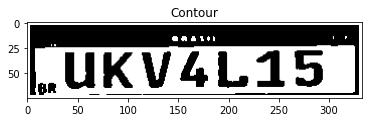

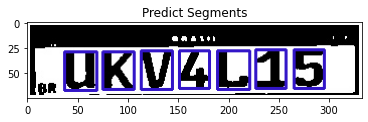

1/1 [==============================] - 0s 32ms/step
94


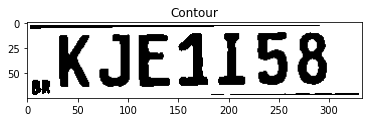

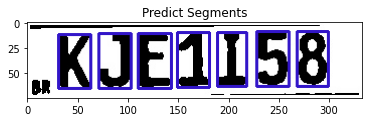

1/1 [==============================] - 0s 37ms/step
95


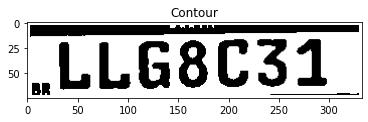

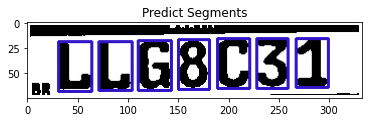

1/1 [==============================] - 0s 35ms/step
96


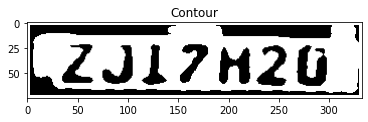

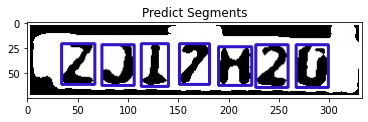

1/1 [==============================] - 0s 39ms/step
97


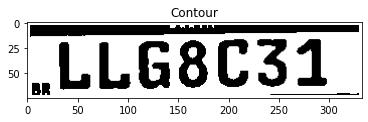

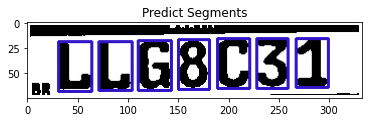

1/1 [==============================] - 0s 42ms/step
98


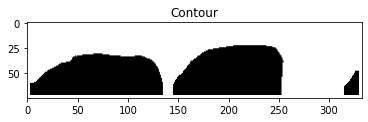

99


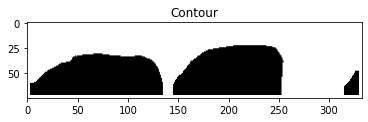

100


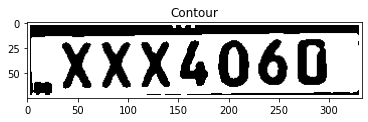

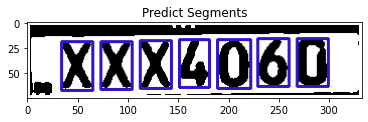

1/1 [==============================] - 0s 45ms/step
101


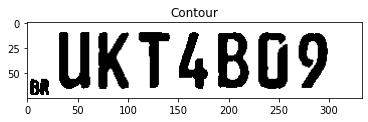

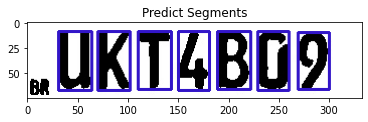

1/1 [==============================] - 0s 41ms/step
102


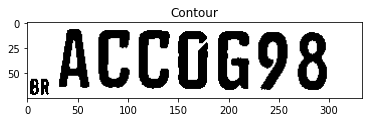

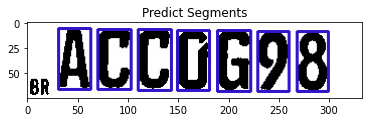

1/1 [==============================] - 0s 40ms/step
103


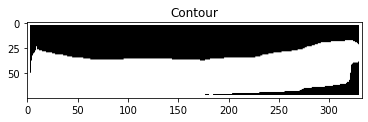

104


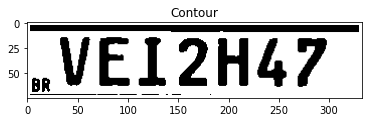

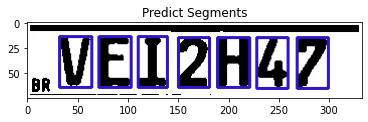

1/1 [==============================] - 0s 44ms/step
105


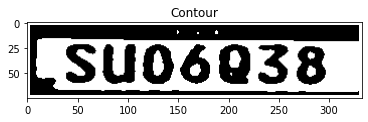

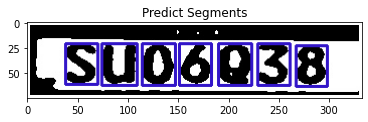

1/1 [==============================] - 0s 39ms/step
106


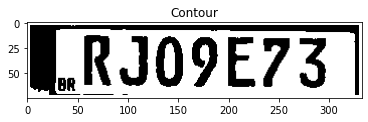

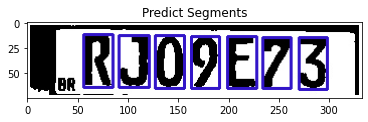

1/1 [==============================] - 0s 40ms/step
107


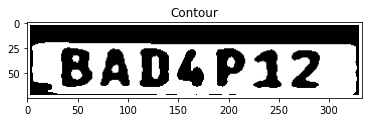

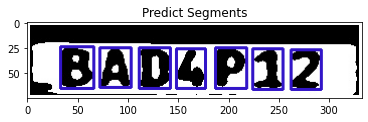

1/1 [==============================] - 0s 38ms/step
108


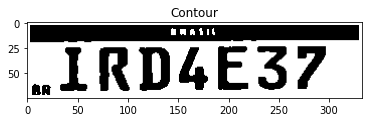

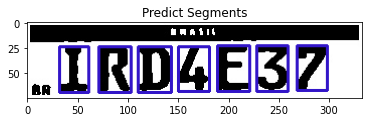

1/1 [==============================] - 0s 42ms/step
109


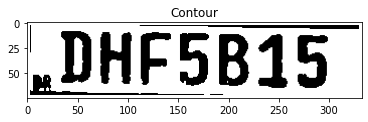

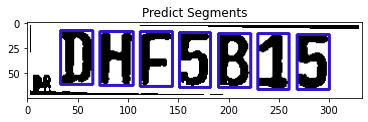

1/1 [==============================] - 0s 45ms/step
110


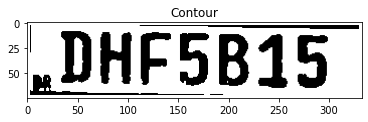

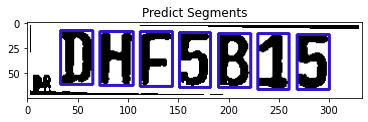

1/1 [==============================] - 0s 47ms/step
111


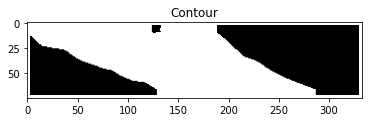

112


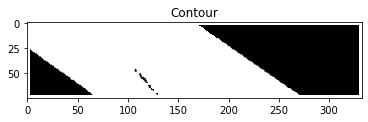

113


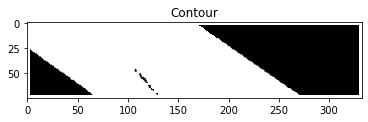

114


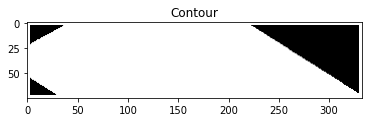

115


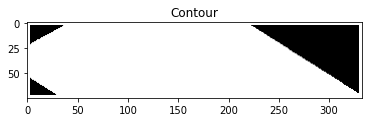

116


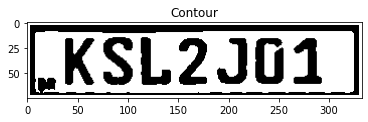

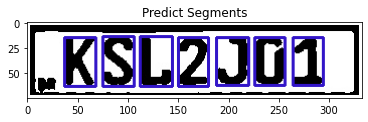

1/1 [==============================] - 0s 47ms/step
117


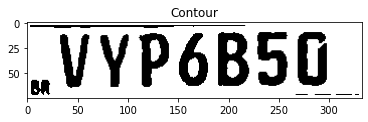

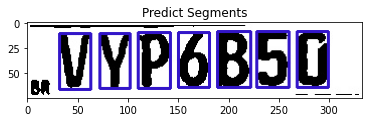

1/1 [==============================] - 0s 45ms/step
118


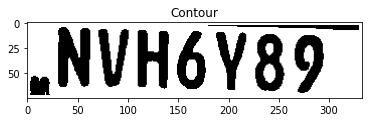

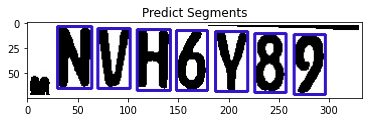

1/1 [==============================] - 0s 43ms/step
119


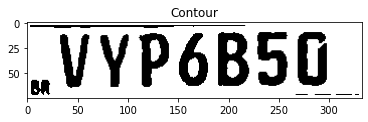

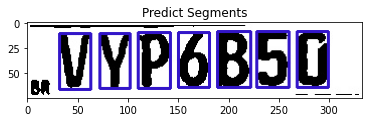

1/1 [==============================] - 0s 46ms/step
120


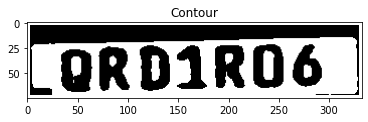

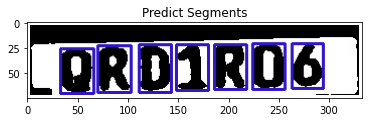

1/1 [==============================] - 0s 51ms/step
121


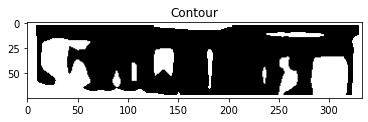

122


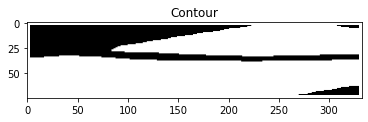

123


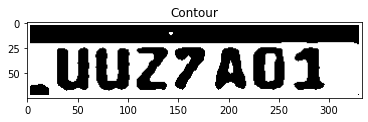

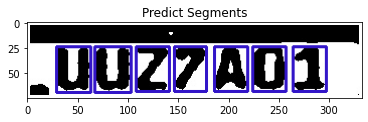

1/1 [==============================] - 0s 45ms/step
124


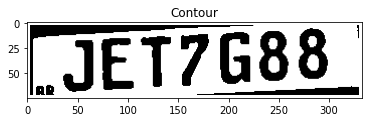

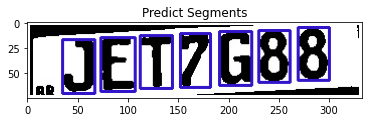

1/1 [==============================] - 0s 43ms/step
125


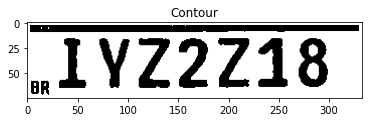

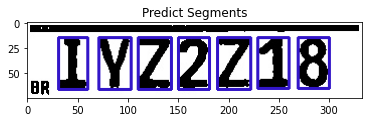

1/1 [==============================] - 0s 52ms/step
126


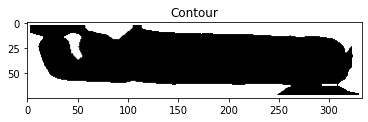

127


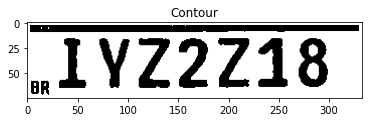

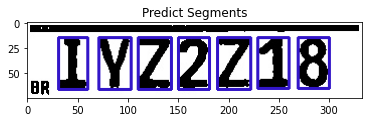

1/1 [==============================] - 0s 42ms/step
128


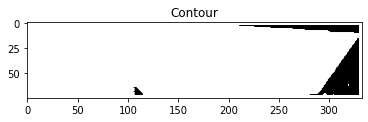

129


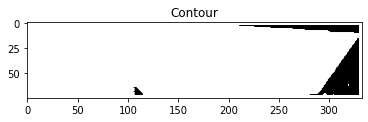

130


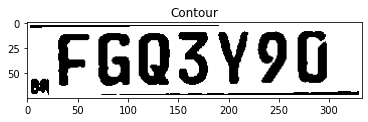

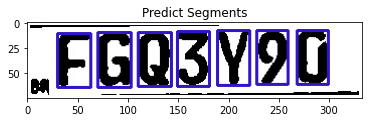

1/1 [==============================] - 0s 47ms/step
131


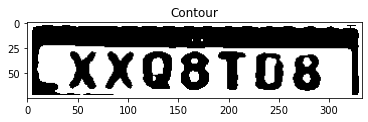

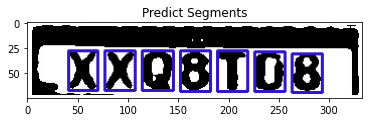

1/1 [==============================] - 0s 42ms/step
132


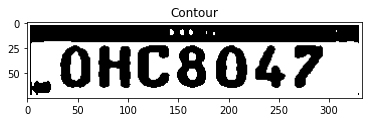

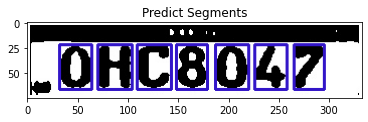

1/1 [==============================] - 0s 44ms/step
133


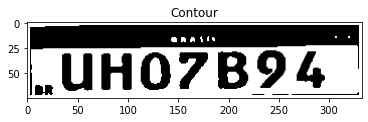

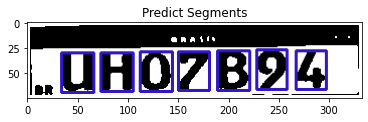

1/1 [==============================] - 0s 43ms/step
134


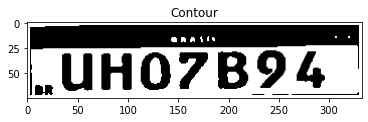

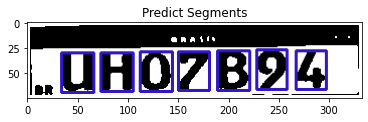

1/1 [==============================] - 0s 42ms/step
135


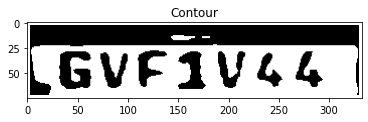

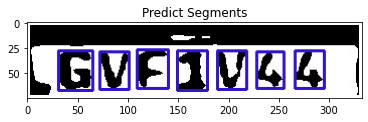

1/1 [==============================] - 0s 46ms/step
136


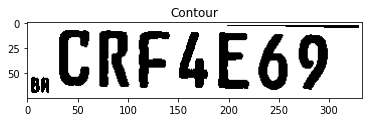

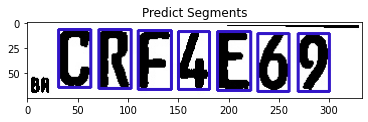

1/1 [==============================] - 0s 51ms/step
137


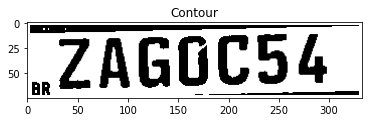

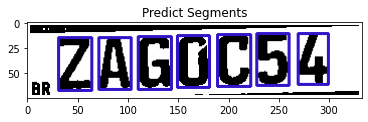

1/1 [==============================] - 0s 40ms/step
138


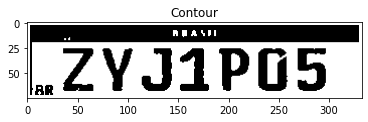

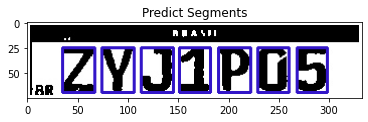

1/1 [==============================] - 0s 43ms/step
139


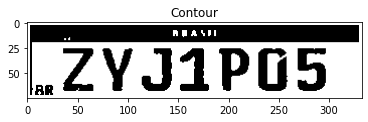

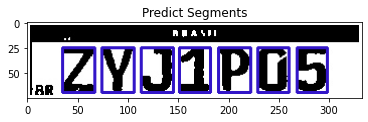

1/1 [==============================] - 0s 44ms/step
140


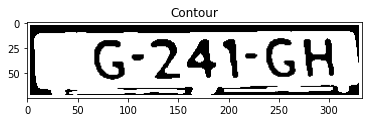

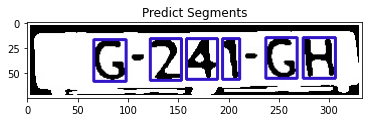

1/1 [==============================] - 0s 42ms/step
141


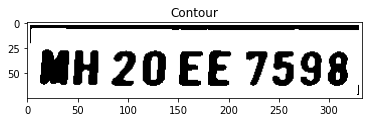

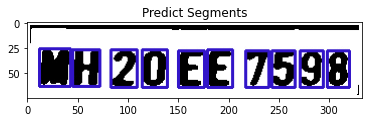

1/1 [==============================] - 0s 40ms/step
142


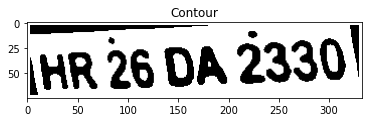

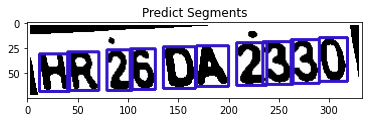

1/1 [==============================] - 0s 47ms/step
143


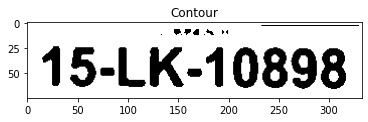

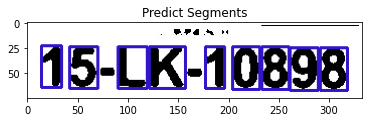

1/1 [==============================] - 0s 49ms/step
144


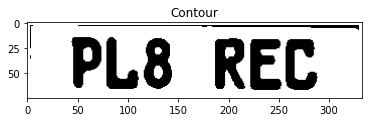

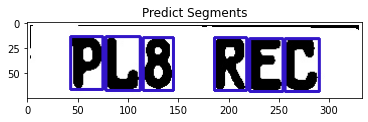

1/1 [==============================] - 0s 42ms/step
145


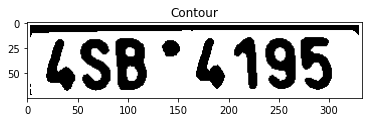

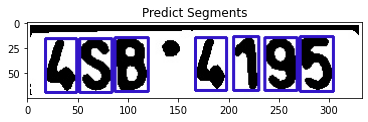

1/1 [==============================] - 0s 50ms/step
146


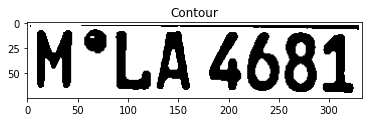

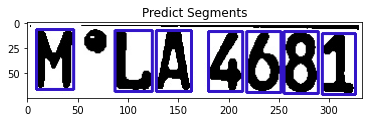

1/1 [==============================] - 0s 55ms/step
147


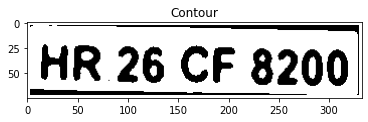

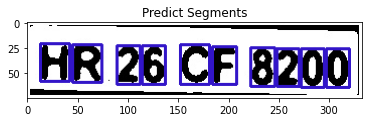

1/1 [==============================] - 0s 56ms/step
148


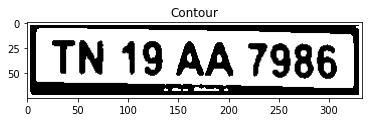

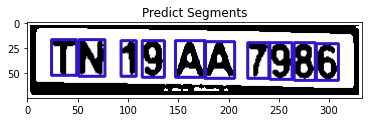

1/1 [==============================] - 0s 43ms/step
149


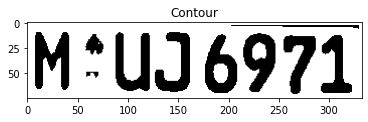

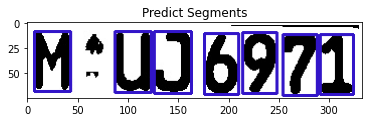

1/1 [==============================] - 0s 45ms/step
150


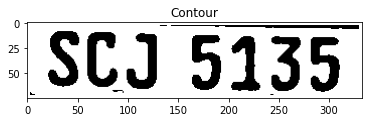

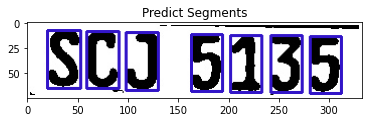

1/1 [==============================] - 0s 43ms/step
151


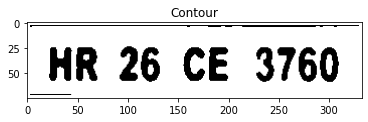

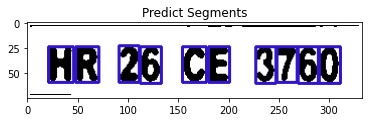

1/1 [==============================] - 0s 42ms/step
152


In [119]:
file_list=os.listdir(r"/content/drive/MyDrive/License-Plate-Number-Detection-main/test_dataset/images")
count=0
k=0
k1=0
empty_list=[]
for path in file_list:
    no=path[:-4]
    image = cv2.imread('/content/drive/MyDrive/License-Plate-Number-Detection-main/test_dataset/images/'+path)
    # Resize the image - change width to 500
    image = imutils.resize(image, width=500)
    img=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # RGB to Gray scale conversion
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Noise removal with iterative bilateral filter(removes noise while preserving edges)
    gray = cv2.bilateralFilter(gray, 11, 17, 17)

    # Find Edges of the grayscale image
    edged = cv2.Canny(gray, 170, 200)

    # Find contours based on Edges
    cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
    cnts=sorted(cnts, key = cv2.contourArea, reverse = True)[:30] #sort contours based on their area keeping minimum required area as '30' (anything smaller than this will not be considered)
    NumberPlateCnt = None #we currently have no Number plate contour

    # loop over our contours to find the best possible approximate contour of number plate
    for c in cnts:
            peri = cv2.arcLength(c, True)
            approx = cv2.approxPolyDP(c, 0.02 * peri, True)
            if len(approx) == 4:  # Select the contour with 4 corners
                NumberPlateCnt = approx #This is our approx Number Plate Contour
                x,y,w,h = cv2.boundingRect(c)
                ROI = img[y:y+h, x:x+w]
                break

    idx=0
    m=0
    if NumberPlateCnt is None:
        k1=k1+1
        empty_list.append('NA')
        continue
    for i in range(4):
        if NumberPlateCnt[i][0][1]>m:
            idx=i
            m=NumberPlateCnt[i][0][1]
    if idx==0:
        pin=3
    else:
        pin=idx-1
    if idx==3:
        nin=0
    else:
        nin=idx+1

    p=dist(NumberPlateCnt[idx][0][0], NumberPlateCnt[pin][0][0], NumberPlateCnt[idx][0][1], NumberPlateCnt[pin][0][1])
    n=dist(NumberPlateCnt[idx][0][0], NumberPlateCnt[nin][0][0], NumberPlateCnt[idx][0][1], NumberPlateCnt[nin][0][1])

    if p>n:
        if NumberPlateCnt[pin][0][0]<NumberPlateCnt[idx][0][0]:
            left=pin
            right=idx
        else:
            left=idx
            right=pin
        d=p
    else:
        if NumberPlateCnt[nin][0][0]<NumberPlateCnt[idx][0][0]:
            left=nin
            right=idx
        else:
            left=idx
            right=nin
        d=n
    left_x=NumberPlateCnt[left][0][0]
    left_y=NumberPlateCnt[left][0][1]
    right_x=NumberPlateCnt[right][0][0]
    right_y=NumberPlateCnt[right][0][1]

    opp=right_y-left_y
    hyp=((left_x-right_x)**2+(left_y-right_y)**2)**0.5
    sin=opp/hyp
    theta=math.asin(sin)*57.2958

    image_center = tuple(np.array(ROI.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, theta, 1.0)
    result = cv2.warpAffine(ROI, rot_mat, ROI.shape[1::-1], flags=cv2.INTER_LINEAR)

    if opp>0:
        h=result.shape[0]-opp//2
    else:
        h=result.shape[0]+opp//2

    result=result[0:h, :]
    char=segment_characters(result)
    plate=show_results1(char)
    k = k + 1
    print(k)
    empty_list.append(plate)
  



In [120]:
k1+k

166

In [121]:
len(empty_list)


166

In [122]:
len(labels['NUMBER'])

166

In [123]:
from difflib import SequenceMatcher


In [126]:
count=0
for i in range(166):
  if(SequenceMatcher(a=empty_list[i],b=labels['NUMBER'][i]).ratio() >= 0.14):
    count=count+1
print('Accuracy is :',count/166*100,'%')

Accuracy is : 63.85542168674698 %
